# Visualizing Performance Summary for Cell Health Target Variables

**Gregory Way, 2019**

For both binary and regression models.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "assay_themes.R"))

In [2]:
consensus <- "modz"

In [3]:
set.seed(13423)
results_dir <- "results"
figure_dir <- file.path("figures", "summary", consensus)
cytominer_compare_dir <- file.path("figures", "cytominer_comparison", consensus)

dir.create(figure_dir, recursive = TRUE, showWarnings = FALSE)
dir.create(cytominer_compare_dir, recursive = TRUE, showWarnings = FALSE)

## Load Data

In [4]:
# Regression Results
regression_file <- file.path(
    results_dir, 
    paste0("full_cell_health_regression_", consensus, ".tsv.gz")
)
regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all")

# Classification Results
roc_file <- file.path(
    results_dir,
    paste0("full_cell_health_roc_results_", consensus, ".tsv.gz")
)
full_roc_df <- readr::read_tsv(roc_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all")

pr_file <- file.path(
    results_dir,
    paste0("full_cell_health_pr_results_", consensus, ".tsv.gz")
)
full_pr_df <- readr::read_tsv(pr_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all")

# Model Coefficients
coef_file <- file.path(
    results_dir,
    paste0("full_cell_health_coefficients_", consensus, ".tsv.gz")
)
full_coef_df <- readr::read_tsv(coef_file, col_types = readr::cols())

# Model Predictions
y_file <- file.path(
    results_dir,
    paste0("full_cell_health_y_labels_", consensus, ".tsv.gz")
)
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform == "raw")

# Annotated Cell Health Features
feat_file <- file.path(
    "..",
    "1.generate-profiles",
    "data",
    "labels",
    "feature_mapping_annotated.csv"
)
label_df <- readr::read_csv(feat_file, col_types = readr::cols())

## Process Data

In [5]:
regression_subset_df <- regression_metrics_df %>%
    dplyr::filter(y_transform == "raw",
                  data_fit == "test",
                  shuffle == "shuffle_false") %>%
    tidyr::spread(key = "metric", value = "value") %>%
    dplyr::select(-y_transform)

print(dim(regression_subset_df))
head(regression_subset_df, 3)

[1] 70  6


target,data_fit,shuffle,cell_line,mse,r_two
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
cc_all_high_h2ax,test,shuffle_false,all,0.4717389,0.3290470
cc_all_large_notround_polynuclear_mean,test,shuffle_false,all,0.1911086,0.2394573
cc_all_large_round_polyploid_mean,test,shuffle_false,all,0.3338191,-0.3926279


In [6]:
auroc_df <- full_roc_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

aupr_df <- full_pr_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

auc_df <- dplyr::bind_rows(auroc_df, aupr_df) %>%
    dplyr::filter(shuffle == "shuffle_false")

auc_df$metric <- dplyr::recode_factor(
    auc_df$metric,
    "roc" = "AUROC",
    "aupr" = "AUPR"
)

auc_df <- auc_df %>%
    tidyr::spread(key = "metric", value = "auc") %>%
    dplyr::select(-y_transform)

test_auc_df <- auc_df %>%
    dplyr::filter(data_fit == "test")

train_auc_df <- auc_df %>%
    dplyr::filter(data_fit == "train") %>%
    dplyr::select(-data_fit)

auc_df <- train_auc_df %>%
    dplyr::full_join(test_auc_df,
                     by = c("target", "shuffle", "min_class_count"),
                     suffix = c("_train", "_test"))

print(dim(auc_df))
head(auc_df, 2)

[1] 63  8


target,shuffle,min_class_count,AUROC_train,AUPR_train,data_fit,AUROC_test,AUPR_test
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
cc_all_high_h2ax,shuffle_false,29,0.9385855,0.6109243,test,0.6458333,0.35280543
cc_all_large_notround_polynuclear_mean,shuffle_false,21,0.8529213,0.3178027,test,0.5849057,0.04347826


In [7]:
metric_df <- regression_subset_df %>%
    dplyr::inner_join(auc_df, by = c("target", "data_fit", "shuffle")) %>%
    dplyr::left_join(label_df, by = c("target" = "id"))

metric_df$mse = abs(metric_df$mse)

metric_df$measurement <- tidyr::replace_na(metric_df$measurement, "other")

metric_df$measurement <- factor(
    metric_df$measurement,
    levels = measurement_levels
)

metric_df$assay <- factor(
    metric_df$assay,
    levels = dye_levels
)

print(dim(metric_df))
head(metric_df, 3)

[1] 63 26


target,data_fit,shuffle,cell_line,mse,r_two,min_class_count,AUROC_train,AUPR_train,AUROC_test,⋯,assay,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
cc_all_high_h2ax,test,shuffle_false,all,0.4717389,0.3290470,29,0.9385855,0.6109243,0.6458333,⋯,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
cc_all_large_notround_polynuclear_mean,test,shuffle_false,all,0.1911086,0.2394573,21,0.8529213,0.3178027,0.5849057,⋯,hoechst,1,0,0,0,0,0,0,0,Fraction of cells with large non-round nuclei (Polynuclear)
cc_all_large_round_polyploid_mean,test,shuffle_false,all,0.3338191,-0.3926279,13,0.9079576,0.2853862,NA,⋯,hoechst,1,0,0,0,0,0,0,0,Large and round cells (Polyploid)


## Plot Performance

Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

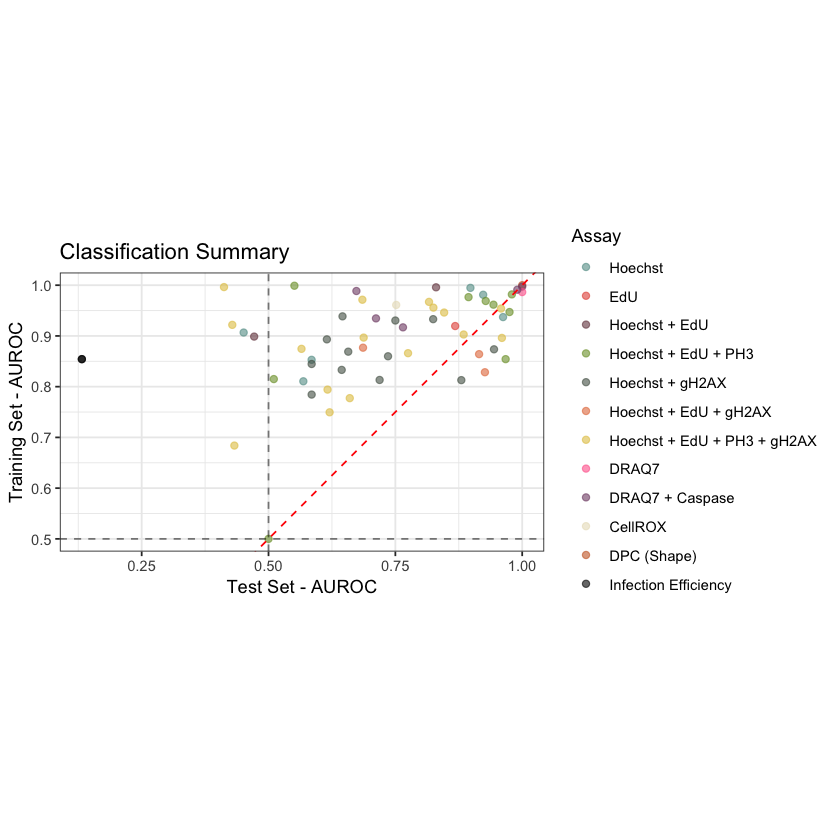

In [8]:
# Note that the points that failed to plot did not contain enough positive samples in test set
ggplot(metric_df,
       aes(x = AUROC_test,
           y = AUROC_train)) +
    geom_point(alpha = 0.6,
               size = 1.7,
               aes(color = assay)) +
    ggtitle("Classification Summary") +
    xlab("Test Set - AUROC") +
    ylab("Training Set - AUROC") +
    geom_vline(xintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_abline(slope = 1,
                intercept = 0, 
                color = "red",
                linetype = "dashed") +
    coord_fixed() +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    theme_bw()

file <- file.path(
    figure_dir,
    paste0("performance_summary_auroc_assay_", consensus, ".png")
)
ggsave(file, dpi = 300, width = 6, height = 4.5)

Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

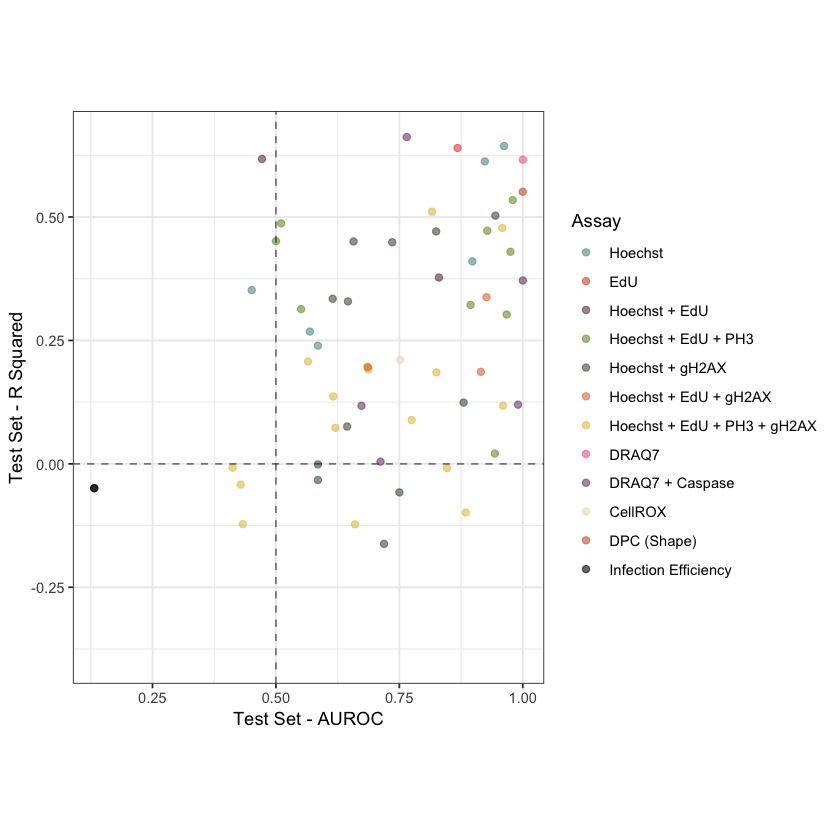

In [9]:
ggplot(metric_df, aes(x = AUROC_test,
                      y = r_two)) +
    geom_point(alpha = 0.6,
               size = 1.7,
               aes(color = assay)) +
    xlab("Test Set - AUROC") +
    ylab("Test Set - R Squared") +
    geom_vline(xintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    coord_fixed() +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    theme_bw()

file <- file.path(
    figure_dir,
    paste0(
        "performance_summary_assay_classification_vs_regression_",
        consensus,
        ".png"
    )
)
ggsave(file, dpi = 300, width = 6, height = 4.5)

## Variable Model Performance Comparing Regression vs. Classification

We observe variable performance across model types.
Regression and classification perform differently in different settings.

Regression is likely to be our primary approach, but in some cases it may be worth presenting a classification model.

Make sure to take into account shuffled model performance

In [10]:
# Get data ready for plotting
auc_test_full_df <- dplyr::bind_rows(auroc_df, aupr_df) %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::filter(data_fit == "test")

auc_test_full_real_df <- auc_test_full_df %>%
    dplyr::filter(shuffle == "shuffle_false") %>%
    dplyr::arrange(target, metric)
auc_test_full_shuffle_df <- auc_test_full_df %>%
    dplyr::filter(shuffle == "shuffle_true") %>%
    dplyr::arrange(target, metric)

real_minus_shuffle_df <- auc_test_full_real_df %>%
    dplyr::mutate(
        auc = auc_test_full_real_df$auc - auc_test_full_shuffle_df$auc,
        shuffle = "real_minus_shuffle"
    )

target_order <- real_minus_shuffle_df %>%
    dplyr::filter(metric == "roc") %>%
    dplyr::arrange(desc(auc)) %>%
    dplyr::pull(target)

auc_test_full_df <- auc_test_full_df %>%
    dplyr::bind_rows(real_minus_shuffle_df)

auc_test_full_df$metric <- auc_test_full_df$metric %>%
    dplyr::recode("aupr" = "AUPR", "roc" = "AUROC")

auc_test_full_df$target <- factor(auc_test_full_df$target, levels = rev(target_order))
auc_test_full_df$metric <- factor(auc_test_full_df$metric, levels = c("AUROC", "AUPR"))

print(dim(auc_test_full_df))
head(auc_test_full_df, 2)

[1] 378  22


metric,target,auc,data_fit,shuffle,y_transform,min_class_count,readable_name,original_name,feature_type,⋯,assay,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
AUROC,cc_all_high_h2ax,0.1979167,test,shuffle_true,binarize,29,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,⋯,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
AUROC,cc_all_high_h2ax,0.6458333,test,shuffle_false,binarize,29,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,⋯,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots


In [11]:
# Get side by side plot
metric_df$target <- factor(metric_df$target, levels = rev(target_order))
metric_df <- metric_df %>%
    dplyr::mutate(r_two_rank = as.numeric(paste(rank(metric_df$r_two, ties.method = "first"))))

head(metric_df, 2)

target,data_fit,shuffle,cell_line,mse,r_two,min_class_count,AUROC_train,AUPR_train,AUROC_test,⋯,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,r_two_rank
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>
cc_all_high_h2ax,test,shuffle_false,all,0.4717389,0.3290470,29,0.9385855,0.6109243,0.6458333,⋯,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,37
cc_all_large_notround_polynuclear_mean,test,shuffle_false,all,0.1911086,0.2394573,21,0.8529213,0.3178027,0.5849057,⋯,1,0,0,0,0,0,0,0,Fraction of cells with large non-round nuclei (Polynuclear),31


## Separate Training and Testing Regression Metrics

In [12]:
r_two_df <- regression_metrics_df %>%
    dplyr::filter(metric == "r_two",
                  shuffle == "shuffle_false",
                  y_transform == "raw") %>%
    tidyr::spread(data_fit, value) %>%
    dplyr::left_join(label_df, by=c("target" = "id"))

r_two_df$measurement <- factor(
    r_two_df$measurement,
    levels = measurement_levels
)
r_two_df$measurement <- tidyr::replace_na(r_two_df$measurement, "other")

r_two_df$assay <- factor(
    r_two_df$assay,
    levels = dye_levels
)

print(dim(r_two_df))
head(r_two_df, 2)

[1] 70 22


metric,target,shuffle,y_transform,cell_line,test,train,readable_name,original_name,feature_type,⋯,assay,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
r_two,cc_all_high_h2ax,shuffle_false,raw,all,0.3290470,0.4747702,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,⋯,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
r_two,cc_all_large_notround_polynuclear_mean,shuffle_false,raw,all,0.2394573,0.5161475,ALL - Polynuclear,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,⋯,hoechst,1,0,0,0,0,0,0,0,Fraction of cells with large non-round nuclei (Polynuclear)


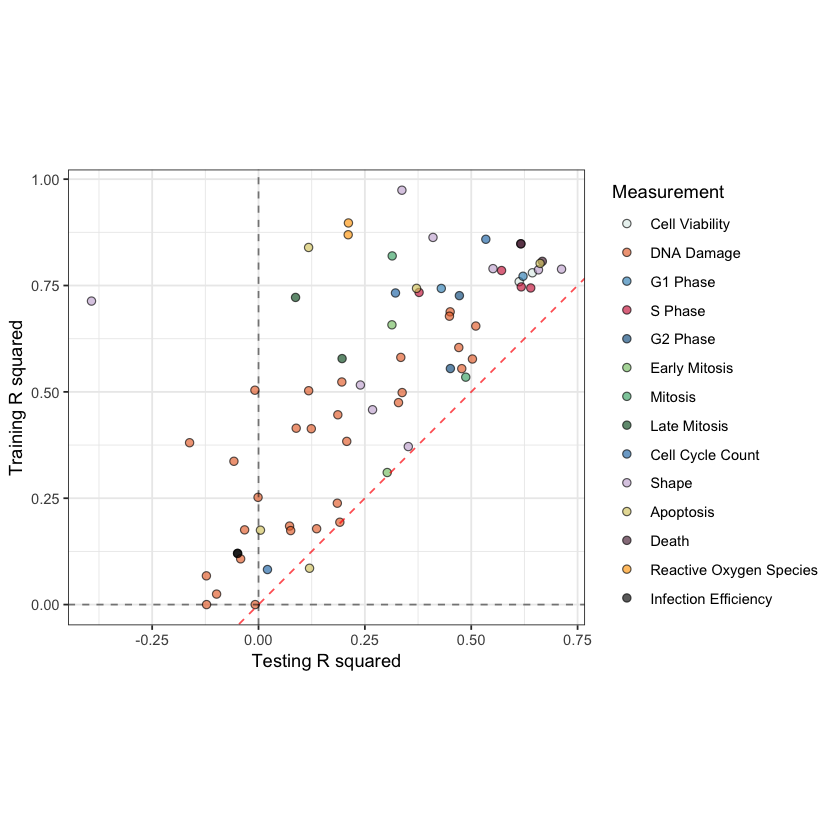

In [13]:
ggplot(r_two_df,
       aes(y = train, x = test)) +
    geom_point(aes(fill = measurement),
               alpha = 0.65,
               size = 2,
               shape = 21,
               color = "black") +
    geom_vline(xintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0,
               alpha = 0.5,
               linetype = "dashed") +
    coord_fixed() +
    ylab("Training R squared") +
    xlab("Testing R squared") +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "red",
                alpha = 0.7) +
    scale_fill_manual(name = "Measurement",
                      values = measurement_colors,
                      labels = measurement_labels) +
    theme_bw()

file <- file.path(
    figure_dir,
    paste0("performance_summary_rsquared_", consensus, ".png")
)
ggsave(file, dpi = 300, width = 6, height = 4.25)

In [14]:
assay_scatter_gg <- ggplot(r_two_df,
       aes(y = train, x = test)) +
    geom_point(aes(fill = assay),
               alpha = 0.72,
               size = 1.5,
               shape = 21,
               color = "black") +
    ylab("Training -  R squared") +
    xlab("Test Set - R squared") +
    geom_vline(xintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_abline(slope = 1,
                intercept = 0, 
                color = "red",
                linetype = "dashed") +
    coord_fixed() +
    scale_fill_manual(name = "Assay",
                      values = dye_colors,
                      labels = dye_labels) +
    theme_bw()

In [15]:
r_two_df$assay_readable <- dplyr::recode_factor(
    r_two_df$assay,
    "hoechst" = 'Hoechst',
    "edu" = 'EdU',
    "hoechst_edu" = 'Hoechst + EdU',
    "hoechst_edu_ph3" = 'Hoechst + EdU + PH3',
    "hoechst_gh2ax" = 'Hoechst + gH2AX',
    "hoechst_edu_gh2ax" = 'Hoechst + EdU + gH2AX',
    "hoechst_edu_ph3_gh2ax" = 'Hoechst + EdU + PH3 + gH2AX',
    "draq" = 'DRAQ7',
    "draq_caspase" = 'DRAQ7 + Caspase',
    "cell_rox" = 'CellROX',
    "dpc" = 'DPC (Shape)',
    "qc" = 'Infection Efficiency'
)

In [16]:
assay_performance_order <- r_two_df %>%
    dplyr::group_by(assay_readable) %>%
    dplyr::mutate(median_assay = median(test)) %>%
    dplyr::select(assay_readable, median_assay) %>%
    dplyr::distinct() %>%
    dplyr::arrange(desc(median_assay)) %>%
    dplyr::pull(assay_readable)

r_two_df$assay_readable <- factor(r_two_df$assay_readable, levels = assay_performance_order)

In [17]:
assay_boxplot_gg <- ggplot(r_two_df,
       aes(y = test, x = assay_readable)) +
    geom_boxplot(fill = "grey",
                 alpha = 0.72,
                 size = 0.5,
                 color = "black",
                 outlier.alpha = 0) +
 geom_jitter(fill = "black",
             alpha = 0.72,
             size = 1.5,
             shape = 21,
             width = 0.1,
             color = "black") +
    ylab("Test Set - R squared") +
    xlab("") +
    geom_hline(yintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8),
          legend.position = "none")

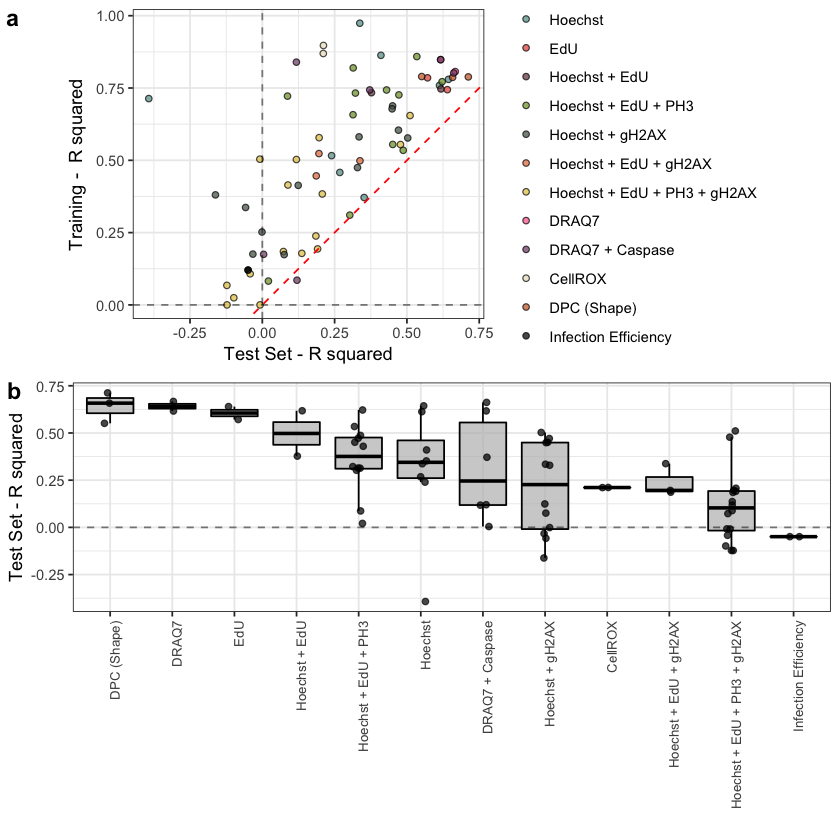

In [18]:
assay_sup_fig_gg <- cowplot::plot_grid(
    assay_scatter_gg,
    assay_boxplot_gg,
    nrow = 2,
    align = "v",
    axis = "l",
    rel_heights = c(0.8, 1),
    labels = c("a", "b")
)

output_file <- file.path(
    figure_dir,
    paste0("performance_summary_rsquared_assay_", consensus, ".png")
)

cowplot::save_plot(output_file, assay_sup_fig_gg, base_width = 6, base_height = 8)

assay_sup_fig_gg

## Compare cytominer with pycytominer

Note that the two classification binarize transforms are different between cytominer and pycytominer.
Many more "positive" samples are included in the cytominer eval.

In [19]:
# Cytominer results are archived on github
hash = "26d1095c209d402102494c0c28e978476643e572"

### Regression Results

In [20]:
cyto_file = paste0(
    "https://github.com/broadinstitute/cell-health/raw/",
    hash,
    "/3.train/results/full_cell_health_regression_results.tsv.gz"
)

cyto_regression_df = readr::read_tsv(cyto_file, col_types=readr::cols()) %>%
    dplyr::mutate(package = "cytominer")

head(cyto_regression_df, 2)

mse,metric,target,data_fit,shuffle,y_transform,package
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.6590045,mse,cc_all_high_n_spots_h2ax_mean,train,shuffle_true,raw,cytominer
0.4247787,mse,cc_all_high_n_spots_h2ax_mean,test,shuffle_true,raw,cytominer


In [21]:
regression_metrics_df <- regression_metrics_df %>%
    dplyr::mutate(package = "pycytominer")

head(regression_metrics_df, 2)

value,metric,target,data_fit,shuffle,y_transform,cell_line,package
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.3770044,mse,cc_all_high_h2ax,train,shuffle_true,raw,all,pycytominer
0.6816362,mse,cc_all_high_h2ax,test,shuffle_true,raw,all,pycytominer


In [22]:
# Note that mse_diff is coded as "value" in pycytominer and "mse" in cytominer
all_regression_df <- regression_metrics_df %>%
    dplyr::inner_join(
        cyto_regression_df,
        by = c("metric", "target", "data_fit", "shuffle", "y_transform"),
        suffix = c("_pycytominer", "_cytominer")
    ) %>%
    dplyr::mutate(mse_diff = value - mse)

head(all_regression_df, 2)

value,metric,target,data_fit,shuffle,y_transform,cell_line,package_pycytominer,mse,package_cytominer,mse_diff
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
0.7062435,mse,cc_all_large_notround_polynuclear_mean,train,shuffle_true,raw,all,pycytominer,0.7397775,cytominer,-0.0335340
0.3238694,mse,cc_all_large_notround_polynuclear_mean,test,shuffle_true,raw,all,pycytominer,0.9861859,cytominer,-0.6623165


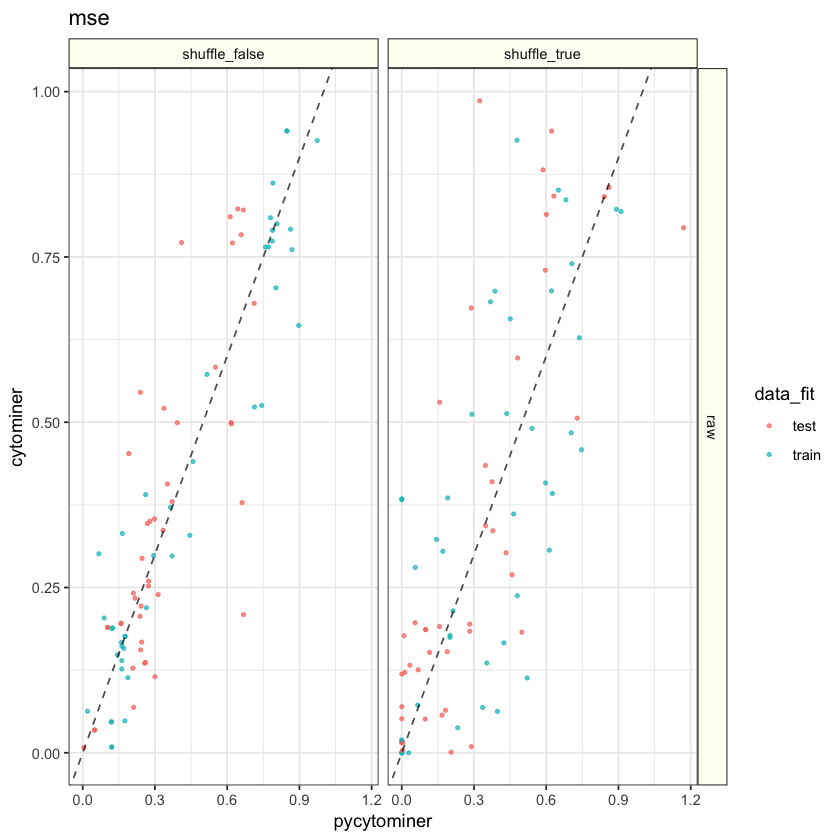

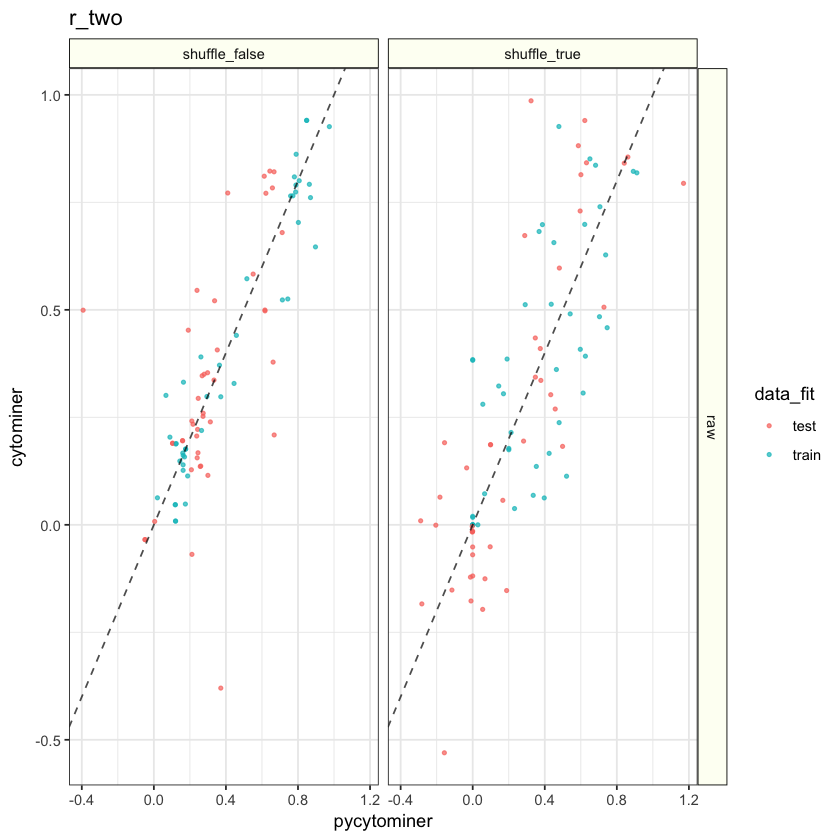

In [23]:
for (metric in unique(all_regression_df$metric)) {
    all_regression_subset_df <- all_regression_df %>%
        dplyr::filter(metric == metric)
    
    if (metric == "mse") {
        all_regression_subset_df$value <- abs(all_regression_subset_df$value)
        all_regression_subset_df$mse <- abs(all_regression_subset_df$mse)
    }
    
    mse_gg <- ggplot(all_regression_subset_df,
       aes(x=value, 
           y=mse)) +
    geom_point(aes(color = data_fit),
               alpha = 0.7,
               size = 0.8) +
    facet_grid(y_transform~shuffle) +
    xlab("pycytominer") +
    ylab("cytominer") +
    ggtitle(metric) +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    theme_bw() +
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))
    
    print(mse_gg)
    outfile <- file.path(
        cytominer_compare_dir,
        paste0("compare_pycytominer_cytominer_", metric, "_", consensus, ".png")
    )
    ggsave(outfile, height = 5, width = 6, dpi = 300)
}



In [24]:
all_regression_df %>%
    dplyr::group_by(metric, data_fit, shuffle, y_transform) %>%
    dplyr::mutate(percent_pycytominer_better = sum(mse_diff > 0) / n()) %>%
    dplyr::distinct(metric, data_fit, shuffle, y_transform, percent_pycytominer_better)

metric,data_fit,shuffle,y_transform,percent_pycytominer_better
<chr>,<chr>,<chr>,<chr>,<dbl>
mse,train,shuffle_true,raw,0.5909091
mse,test,shuffle_true,raw,0.4545455
r_two,train,shuffle_true,raw,0.3181818
r_two,test,shuffle_true,raw,0.7272727
mse,train,shuffle_false,raw,0.5000000
mse,test,shuffle_false,raw,0.5454545
r_two,train,shuffle_false,raw,0.6818182
r_two,test,shuffle_false,raw,0.2727273


### Classification Comparison

In [25]:
# Cytominer results are archived on github
cyto_file = paste0(
    "https://github.com/broadinstitute/cell-health/raw/",
    hash,
    "/3.train/results/full_cell_health_roc_results.tsv.gz"
)

cyto_roc_df = readr::read_tsv(cyto_file, col_types=readr::cols())

head(cyto_roc_df, 2)

fpr,tpr,threshold,metric,target,auc,data_fit,shuffle,y_transform,min_class_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
0,0.000000000,8.538085,roc,cc_all_high_n_spots_h2ax_mean,0.9018822,train,shuffle_true,binarize,151
0,0.006578947,7.538085,roc,cc_all_high_n_spots_h2ax_mean,0.9018822,train,shuffle_true,binarize,151


In [26]:
cyto_file = paste0(
    "https://github.com/broadinstitute/cell-health/raw/",
    hash,
    "/3.train/results/full_cell_health_pr_results.tsv.gz"
)

cyto_pr_df = readr::read_tsv(cyto_file, col_types=readr::cols())

head(cyto_pr_df, 2)

precision,recall,threshold,metric,target,auc,data_fit,shuffle,y_transform,min_class_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
0.5779468,1.0000000,-0.8279075,aupr,cc_all_high_n_spots_h2ax_mean,0.9145002,train,shuffle_true,binarize,151
0.5763359,0.9934211,-0.8254211,aupr,cc_all_high_n_spots_h2ax_mean,0.9145002,train,shuffle_true,binarize,151


In [27]:
cyto_auroc_df <- cyto_roc_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

cyto_aupr_df <- cyto_pr_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

cyto_auc_df <- dplyr::bind_rows(cyto_auroc_df, cyto_aupr_df) %>%
    dplyr::filter(shuffle == "shuffle_false",
                  data_fit == "test")

cyto_auc_df$metric <- dplyr::recode_factor(
    cyto_auc_df$metric,
    "roc" = "AUROC",
    "aupr" = "AUPR"
)

cyto_auc_df <- cyto_auc_df %>%
    tidyr::spread(key = "metric", value = "auc") %>%
    dplyr::select(-y_transform) %>%
    dplyr::mutate(package = "cytominer")

print(dim(cyto_auc_df))
head(cyto_auc_df, 2)

[1] 68  7


target,data_fit,shuffle,min_class_count,AUROC,AUPR,package
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,151,0.7750343,0.7919861,cytominer
cc_all_large_notround_polynuclear_mean,test,shuffle_false,151,0.5226337,0.5404478,cytominer


In [28]:
auc_df <- auc_df %>%
    dplyr::mutate(package = "pycytominer")

In [29]:
all_classification_df <- auc_df %>%
    dplyr::inner_join(cyto_auc_df,
                      by = c("target", "data_fit", "shuffle"),
                      suffix = c("_pycytominer", "_cytominer")) %>%
    dplyr::mutate(auroc_diff = AUROC_test - AUROC,
                  aupr_diff = AUPR_test - AUPR) %>%
    dplyr::filter(data_fit == "test",
                  shuffle == "shuffle_false") 

head(all_classification_df, 2)

target,shuffle,min_class_count_pycytominer,AUROC_train,AUPR_train,data_fit,AUROC_test,AUPR_test,package_pycytominer,min_class_count_cytominer,AUROC,AUPR,package_cytominer,auroc_diff,aupr_diff
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
cc_all_large_notround_polynuclear_mean,shuffle_false,21,0.8529213,0.3178027,test,0.5849057,0.04347826,pycytominer,151,0.5226337,0.5404478,cytominer,0.06227192,-0.4969696
cc_all_large_round_polyploid_mean,shuffle_false,13,0.9079576,0.2853862,test,NA,NA,pycytominer,151,0.6351166,0.7209584,cytominer,NA,NA


Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

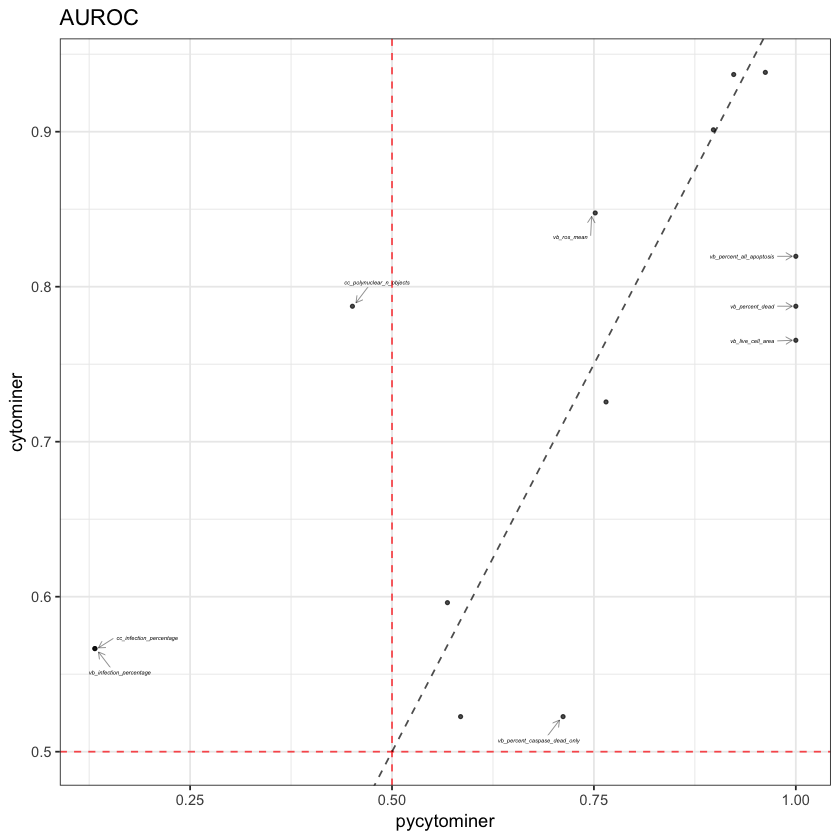

In [30]:
metric <- "AUROC"

label_logic <- abs(all_classification_df$auroc_diff) > 0.08

ggplot(all_classification_df,
       aes(x = AUROC_test, 
           y = AUROC)) +
    geom_point(alpha = 0.7,
               size = 0.8) +
    xlab("pycytominer") +
    ylab("cytominer") +
    geom_hline(yintercept = 0.5,
               linetype = "dashed",
               color = "red",
               alpha = 0.7) +
    geom_vline(xintercept = 0.5,
               linetype = "dashed",
               color = "red",
               alpha = 0.7) +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    ggtitle(metric) +
    geom_text_repel(data = subset(all_classification_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.6,
                    point.padding = 0.3,
                    segment.size = 0.2,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    aes(label = target,
                        x = AUROC_test,
                        y = AUROC)) +
    theme_bw()

outfile <- file.path(
    cytominer_compare_dir,
    paste0("compare_pycytominer_cytominer_", metric, "_", consensus, ".png")
)
ggsave(outfile, height = 3, width = 3, dpi = 300)

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

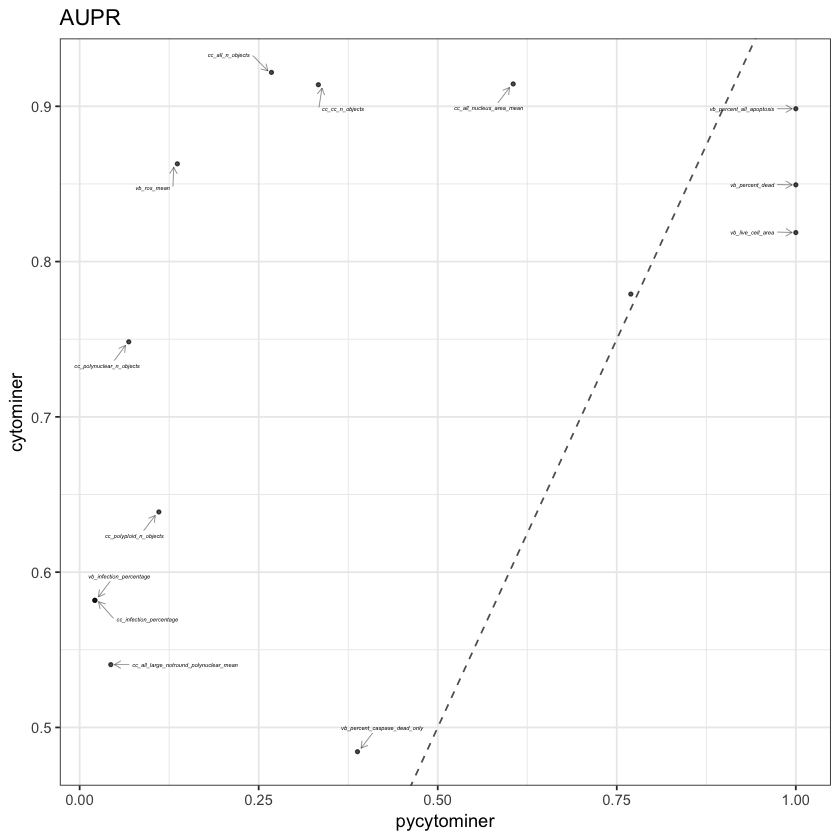

In [31]:
metric <- "AUPR"

label_logic <- abs(all_classification_df$aupr_diff) > 0.08

ggplot(all_classification_df,
       aes(x = AUPR_test, 
           y = AUPR)) +
    geom_point(alpha = 0.7,
               size = 0.8) +
    xlab("pycytominer") +
    ylab("cytominer") +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    ggtitle(metric) +
    geom_text_repel(data = subset(all_classification_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.6,
                    point.padding = 0.3,
                    segment.size = 0.2,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    aes(label = target,
                        x = AUPR_test,
                        y = AUPR)) +
    theme_bw()

outfile <- file.path(
    cytominer_compare_dir,
    paste0("compare_pycytominer_cytominer_", metric, "_", consensus, ".png")
)
ggsave(outfile, height = 3, width = 3, dpi = 300)

In [32]:
all_classification_df %>%
    tidyr::drop_na() %>%
    dplyr::mutate(percent_auroc_pycytominer_better = sum(auroc_diff > 0) / n(),
                  percent_aupr_pycytominer_better = sum(aupr_diff > 0) / n()) %>%
    dplyr::distinct(data_fit, shuffle, percent_auroc_pycytominer_better, percent_aupr_pycytominer_better)

data_fit,shuffle,percent_auroc_pycytominer_better,percent_aupr_pycytominer_better
<chr>,<chr>,<dbl>,<dbl>
test,shuffle_false,0.5,0.2142857
